# Compute several characteristics of a detector network
## Localization and polarization reconstruction

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pyburst as pb
import pyburst.detectors, pyburst.cbc, pyburst.timefreq, pyburst.skymaps, pyburst.utils

### Plotting defaults

In [2]:
%matplotlib notebook

plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['figure.titlesize'] = 'medium'

### Define network

In [3]:
detector_names = ['H1', 'L1', 'V1']
detectors = [pb.detectors.Detector(d) for d in detector_names]

In [4]:
coordsystem = pyburst.skymaps.Coordsystem("geographic")
NSIDE = 2**6
skymap = pyburst.skymaps.Skymap(NSIDE, coordsystem)

### Measure angle between [F+, Fx] plane at current and mirror point

In [ ]:
angle_with_mirror = []
angle_btw_planes = []
angle_btw_dominant_axes = []

for s in skymap.grid_points():

    angle_with_mirror.append(np.degrees(s.angle_with(s.mirror(detectors))))
    
    antenna_pattern = np.array([d.antenna_pattern(s) for d in detectors])
    antenna_pattern_mirror = np.array([d.antenna_pattern(s.mirror(detectors)) for d in detectors])

    normal_plane = np.cross(antenna_pattern[:,0],antenna_pattern[:,1])
    normal_plane /= np.linalg.norm(normal_plane)

    normal_mirror = np.cross(antenna_pattern_mirror[:,0],antenna_pattern_mirror[:,1])
    normal_mirror /= np.linalg.norm(normal_mirror)
        
    angle_btw_planes.append(np.degrees(pb.utils.angle_between(normal_plane,normal_mirror)))

    f_dominant_frame, _ = pb.utils.orthonormalize(antenna_pattern[:,0], \
                                                      antenna_pattern[:,1], \
                                                        dominant_polar_frame=True)
    f_dominant_frame_mirror, _ = pb.utils.orthonormalize(antenna_pattern_mirror[:,0], \
                                                          antenna_pattern_mirror[:,1], \
                                                          dominant_polar_frame=True)

    angle_btw_dominant_axes.append(np.degrees(pb.utils.angle_between(f_dominant_frame[0], \
                                                                    f_dominant_frame_mirror[0])))

angle_with_mirror = np.array(angle_with_mirror)
angle_btw_planes = np.array(angle_btw_planes)
angle_btw_dominant_axes = np.array(angle_btw_dominant_axes)

In [16]:
# compute distance to 0 or to 180 deg
misalignment = lambda theta: np.piecewise(theta, [theta <= 90, theta > 90], [lambda x: x, lambda x: 180-x])

In [18]:
angle_btw_dominant_axes = misalignment(angle_btw_dominant_axes)

### Plotting

In [6]:
# Compute skypoints in the detector plane
network_plane = np.array([detectors[2].location-detectors[0].location, \
                                 detectors[1].location-detectors[0].location])
network_plane_basis,_,_ = np.linalg.svd(network_plane.T)

pts_in_network_plane = []
for phi in np.linspace(0, 2*math.pi, 50):
    pts_in_network_plane.append(pb.skymaps.Skypoint.from_cart(network_plane_basis[:,0] * math.cos(phi) + \
                                               network_plane_basis[:,1] * math.sin(phi), coordsystem))

<IPython.core.display.Javascript object>


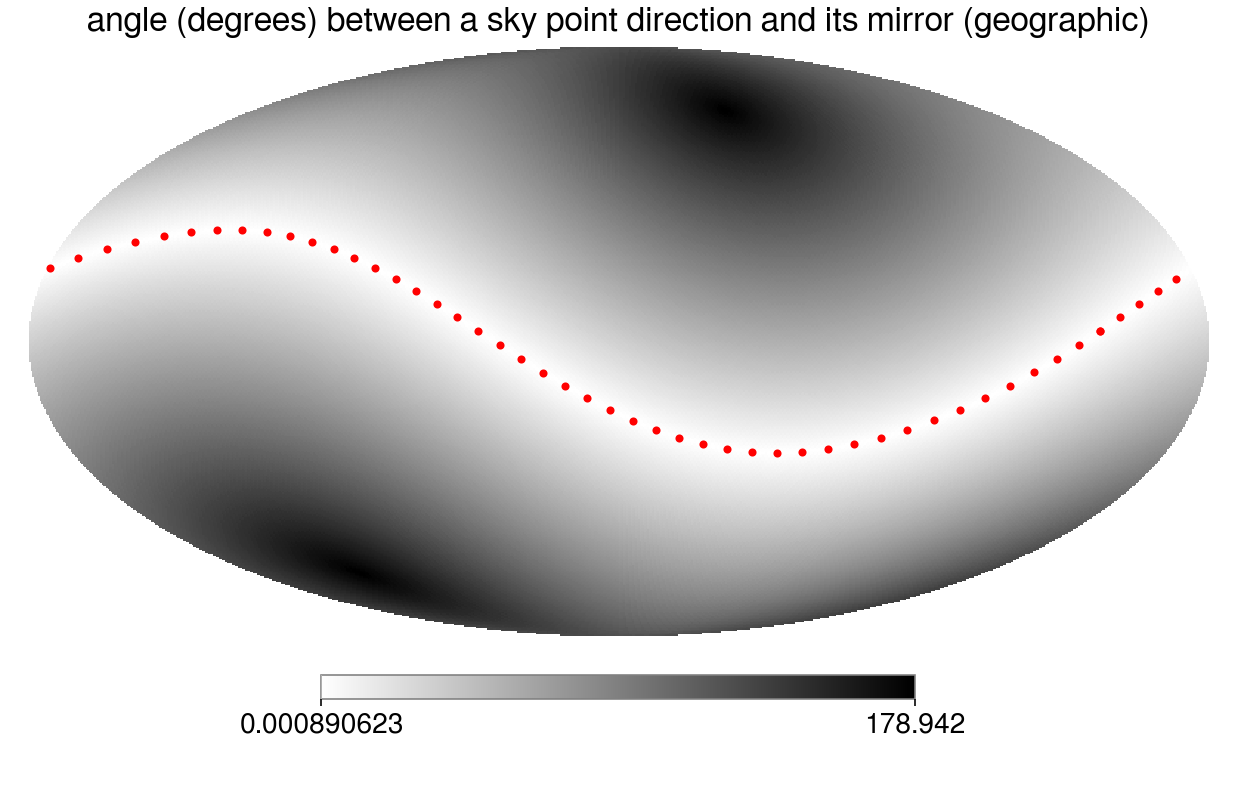

In [7]:
skymap.feed(angle_with_mirror)
skymap.display("angle (degrees) between a sky point direction and its mirror")
for p in pts_in_network_plane:
    p.display('.','r')
plt.show()

<IPython.core.display.Javascript object>


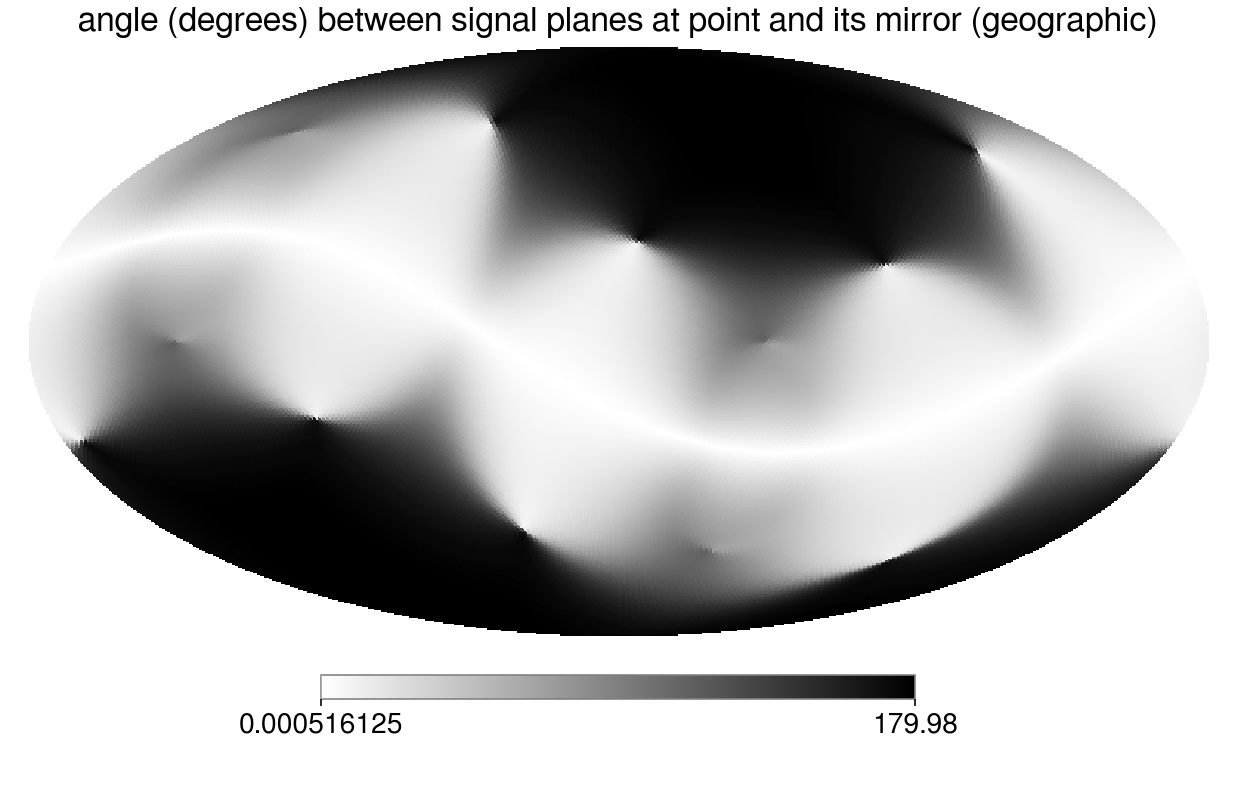

In [8]:
skymap.feed(angle_btw_planes)
skymap.display("angle (degrees) between signal planes at point and its mirror")
plt.show()

<IPython.core.display.Javascript object>


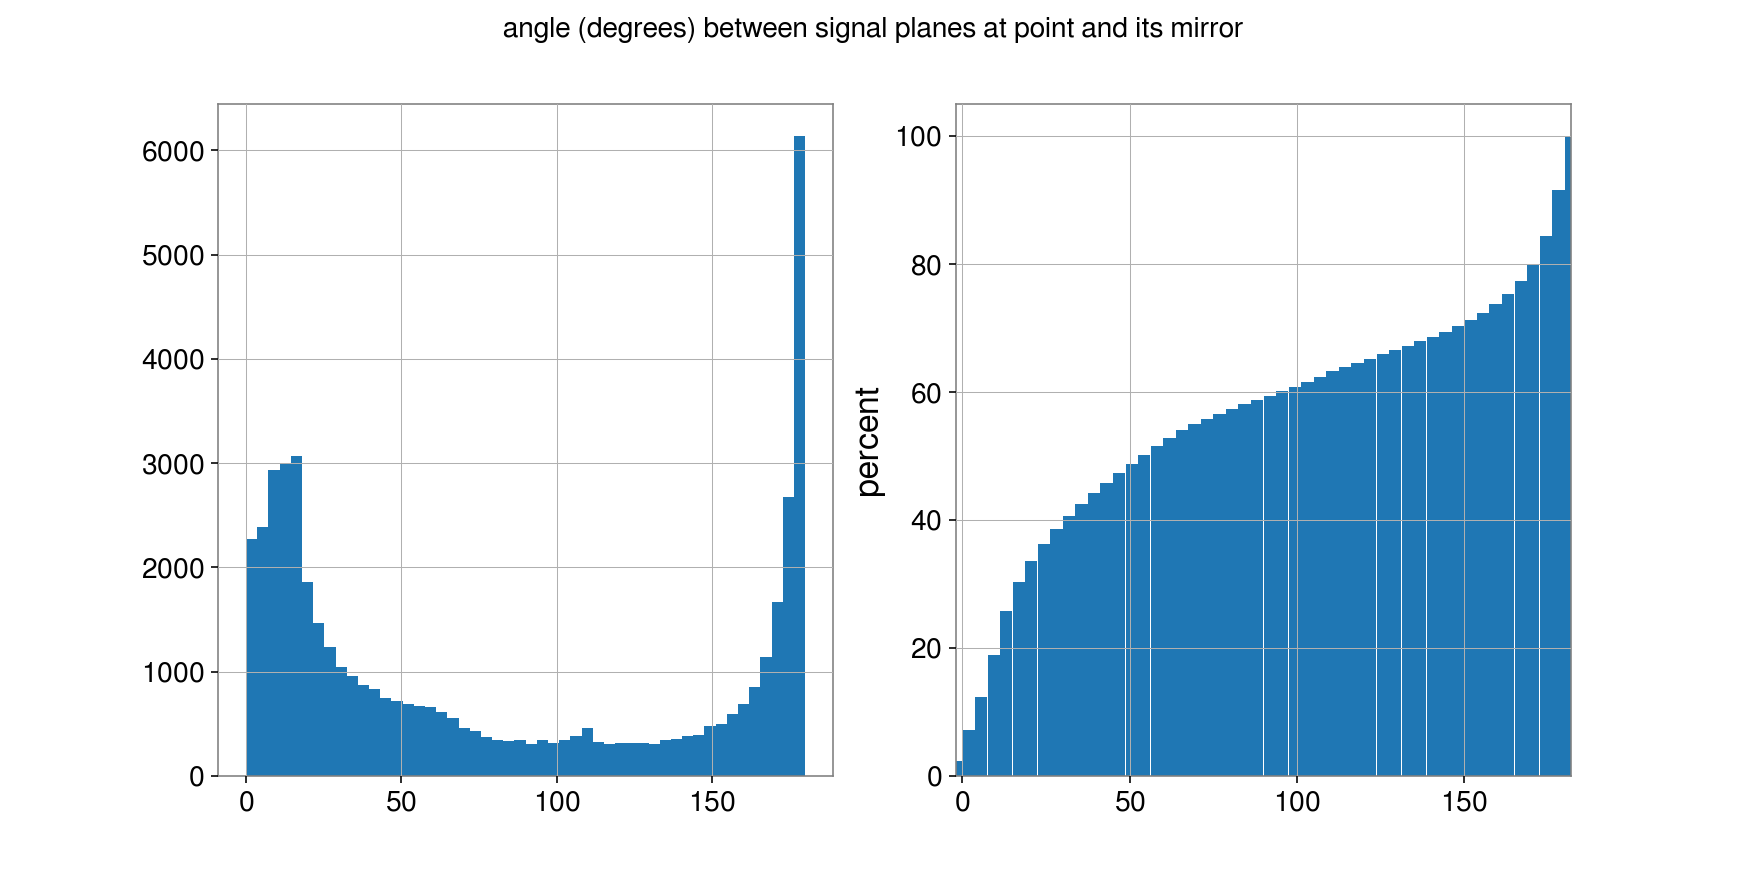

In [9]:
from scipy import stats
h = stats.cumfreq(angle_btw_planes, numbins=50)
bins = h.lowerlimit + \
        np.linspace(0, h.binsize * h.cumcount.size, h.cumcount.size)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(angle_btw_planes, bins=50)
ax2.set_ylabel('counts')
ax2.bar(bins, 100 * h.cumcount/angle_btw_planes.size, width=h.binsize)
ax2.set_ylabel('percent')
ax2.set_xlim([bins.min(), bins.max()])
plt.suptitle("angle (degrees) between signal planes at point and its mirror")
plt.show()

<IPython.core.display.Javascript object>


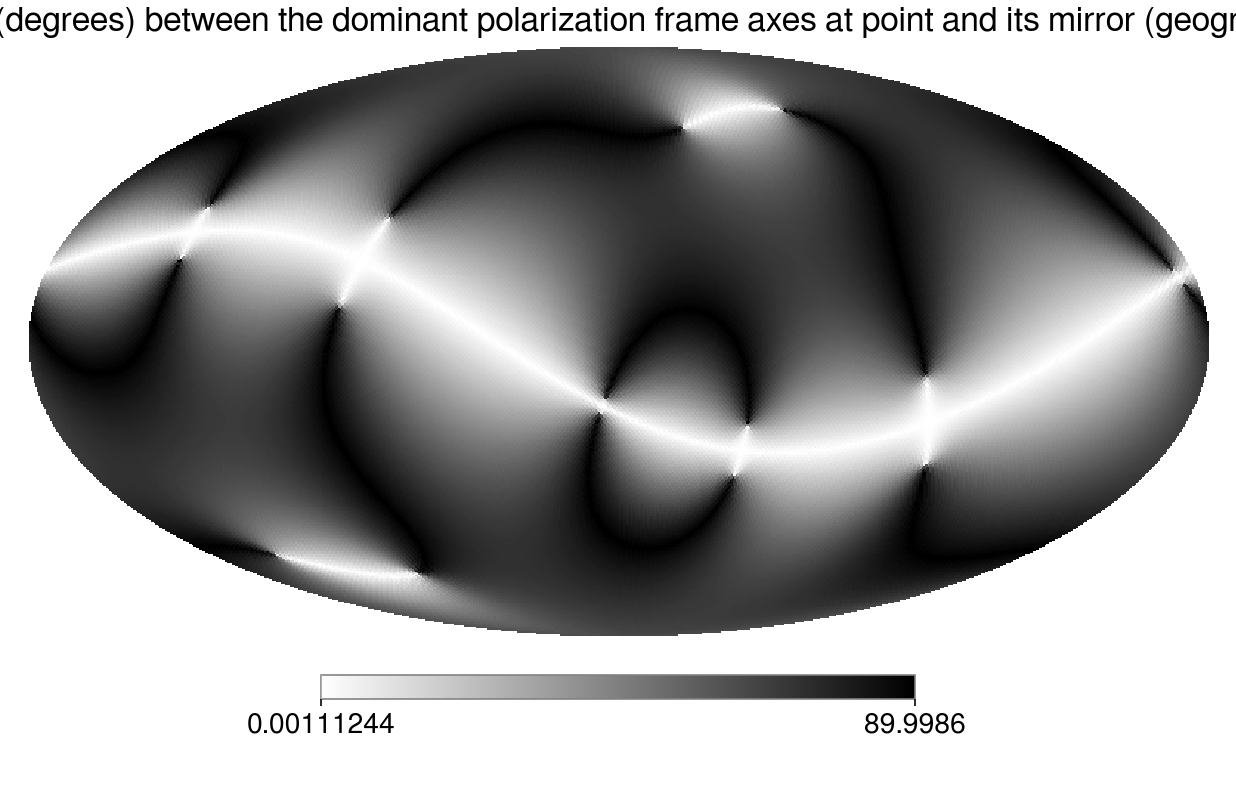

In [19]:
skymap.feed(angle_btw_dominant_axes)
skymap.display("angle (degrees) between the dominant polarization frame axes at point and its mirror")
plt.show()

<IPython.core.display.Javascript object>


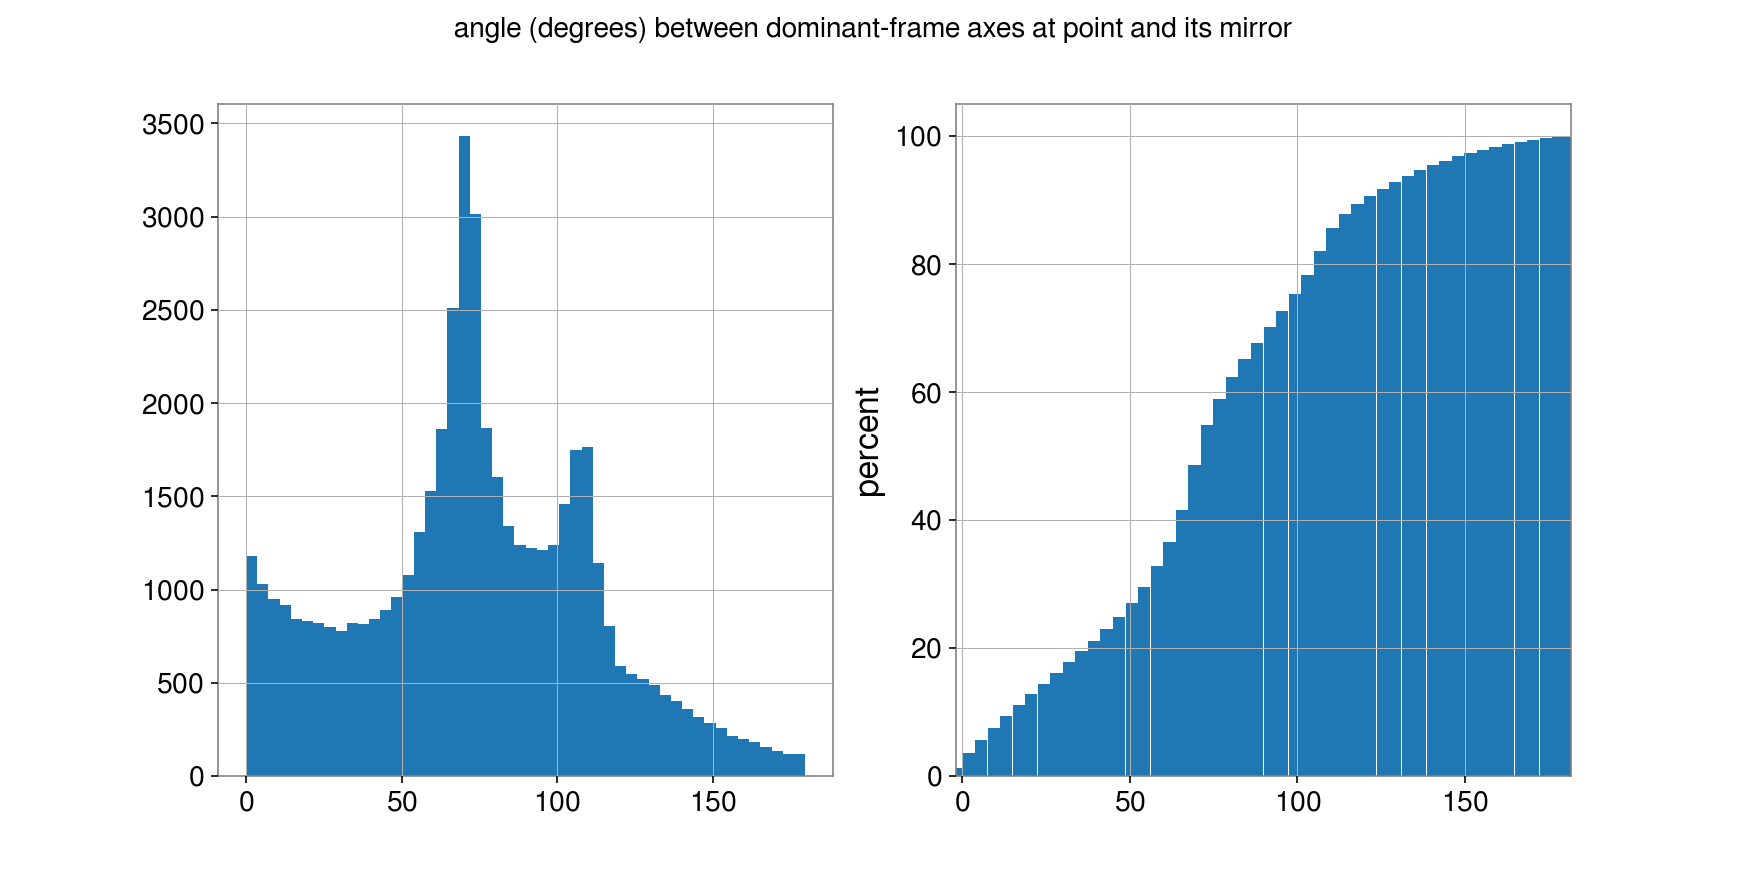

In [11]:
from scipy import stats
h = stats.cumfreq(angle_btw_dominant_axes, numbins=50)
bins = h.lowerlimit + \
        np.linspace(0, h.binsize * h.cumcount.size, h.cumcount.size)
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(angle_btw_dominant_axes, bins=50)
ax2.set_ylabel('counts')
ax2.bar(bins, 100 * h.cumcount/angle_btw_dominant_axes.size, width=h.binsize)
ax2.set_ylabel('percent')
ax2.set_xlim([bins.min(), bins.max()])
plt.suptitle("angle (degrees) between dominant polarization frame axes at point and its mirror")
plt.show()

### Conditioning number

In [12]:
antenna_patterns = np.moveaxis(np.array([d.antenna_pattern(skymap.grid_points()) for d in detectors]),-1,0)

<IPython.core.display.Javascript object>


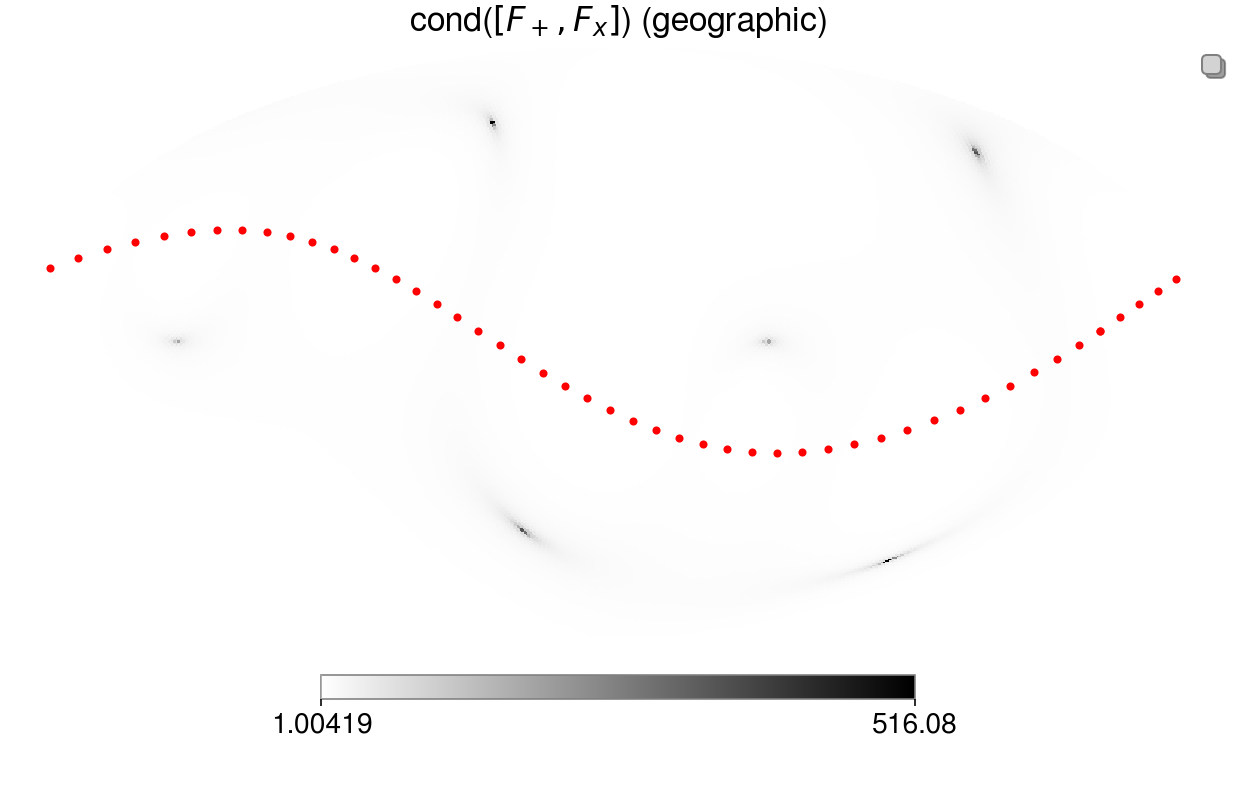

No handles with labels found to put in legend.


In [20]:
skymap.feed(np.linalg.cond(antenna_patterns))
skymap.display("cond($[F_+, F_x]$)")
plt.legend(loc='upper center', bbox_to_anchor=(1, 1),
          ncol=2, fancybox=True, shadow=True, \
          facecolor="lightgray", markerscale = 0.5)
for p in pts_in_network_plane:
    p.display('.','r')
plt.show()

### Smallest singular value

<IPython.core.display.Javascript object>


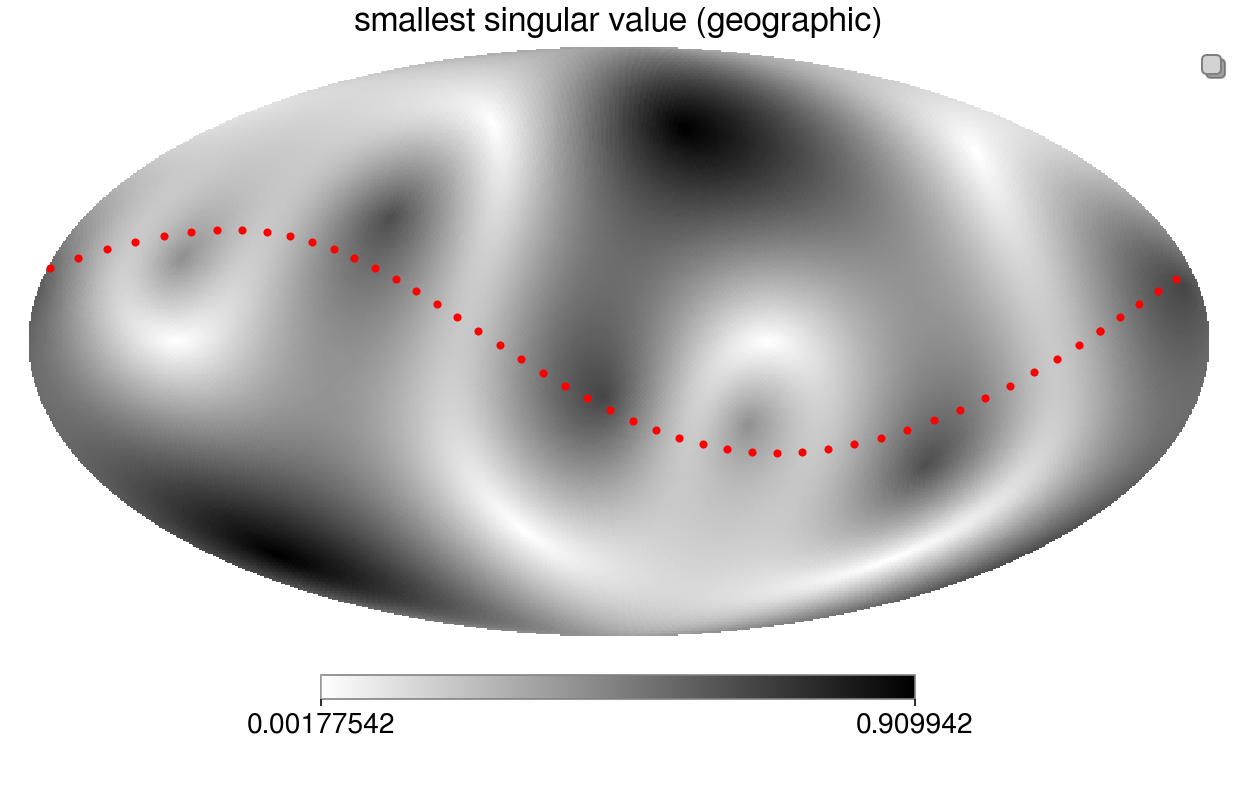

No handles with labels found to put in legend.


In [21]:
skymap.feed(np.linalg.norm(antenna_patterns,axis=(1,2),ord=-2))
skymap.display("smallest singular value")
plt.legend(loc='upper center', bbox_to_anchor=(1, 1),
          ncol=2, fancybox=True, shadow=True, \
          facecolor="lightgray", markerscale = 0.5)
plt.show()